In [2]:
import pandas as pd
from datetime import date, timedelta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# загрузка и преобразование данных
visits = pd.read_csv('visits_log.csv', parse_dates=['End Ts', 'Start Ts'])
orders = pd.read_csv('orders_log.csv', parse_dates=['Buy Ts'])
costs = pd.read_csv('costs.csv', parse_dates=['dt'])

In [4]:
# переименуем колонки
visits.rename(columns={'End Ts':'End_Ts', 'Source Id':'Source_Id', 'Start Ts':'Start_Ts'}, inplace=True)
orders.rename(columns={'Buy Ts':'Buy_Ts'}, inplace=True)
costs.rename(columns={'costs':'cost'}, inplace=True)

### 1. На какой источник было потрачено больше всего денег за год?

In [7]:
advertisement = costs.groupby('source_id', as_index=False)  \
                     .agg({'cost':'sum'})  \
                     .rename(columns={'cost':'total_cost'})  \
                     .sort_values('total_cost', ascending=False)
advertisement

,source_id,total_cost
2,3,141321.63
3,4,61073.60
4,5,51757.10
1,2,42806.04
0,1,20833.27
6,10,5822.49
5,9,5517.49


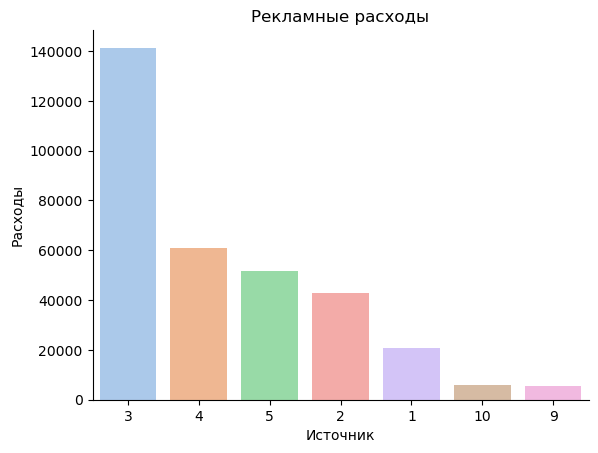

In [8]:
advertisement.source_id = [str(i) for i in advertisement.source_id.values]
ax = sns.barplot(data=advertisement, x='source_id', y='total_cost',  palette='pastel')
ax.set_xlabel('Источник')
ax.set_ylabel('Расходы')
ax.set_title('Рекламные расходы')
sns.despine()

### На источник 3 было потрачено больше всего денег за год

### 2. Найти средний LTV пользователей, которые впервые пришли до декабря

#### LTV = AOV * RPR * Lifetime, где   
AOV - средний чек каждого пользователя   
RPR - частота повторных покупок каждого пользователя за период   
Lifetime — кол-во периодов жизни пользователя (с декабря 2017 по май 2018 - 6 месяцев жизни когорты)

In [9]:
# Отберем пользователей, пришедших до декабря. Определим дату их первого посещения
cohort_until_dec = visits.query('Start_Ts < "2017-12-01"') \
                  .groupby('Uid', as_index=False) \
                  .agg({'Start_Ts':'min'})

# Объединим с данными о покупках
cohort_until_dec_orders = cohort_until_dec.merge(orders, how='left', on='Uid')
cohort_until_dec_orders.head()

,Uid,Start_Ts,Buy_Ts,Revenue
0,297729379853735,2017-06-07 18:47:00,NaT,NaN
1,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,0.55
2,325320750514679,2017-09-30 14:29:00,NaT,NaN
3,407573351275847,2017-06-17 13:40:00,NaT,NaN
4,526778907996220,2017-10-21 17:51:00,NaT,NaN


In [10]:
# рассчитаем необходимые метрики
cohort_metr = cohort_until_dec_orders.groupby('Uid', as_index = False) \
                                     .agg({'Revenue':['mean', 'count']})
# уберем иерархические заголовки
cohort_metr.columns = ['_'.join(col).rstrip('_') for col in cohort_metr.columns.values]

# переименуем столбец
cohort_metr.rename(columns = {'Revenue_mean': 'AOV'}, inplace = True)

# рассчитаем количество повторных покупок в месяц (с декабря 2017 по май 2018 - 6 месяцев жизни когорты)
cohort_metr['RPR'] = cohort_metr.Revenue_count / 6
cohort_metr.head()

,Uid,AOV,Revenue_count,RPR
0,297729379853735,NaN,0,0.000000
1,313578113262317,0.55,1,0.166667
2,325320750514679,NaN,0,0.000000
3,407573351275847,NaN,0,0.000000
4,526778907996220,NaN,0,0.000000


In [12]:
LTV = cohort_metr.AOV.mean() * cohort_metr.RPR.mean() * 6
print('Средний чек когорты: ', round(cohort_metr.AOV.mean(), 2), 
      '\nСреднее кол-во повторных покупок в месяц: ', round(cohort_metr.RPR.mean(), 2),
      '\nLTV = ', round(LTV, 2))

Средний чек когорты:  4.26 
Среднее кол-во повторных покупок в месяц:  0.05 
LTV =  1.17


#### LTV - 1.17   
#### Сравним LTV  с показателем CAC (стоимость привлечения клиента)

In [13]:
CAC = costs.query('dt < "2017-12-01"').cost.sum() / cohort_metr.query('AOV.isna() == False').Uid.nunique()
CAC

7.834858638743455

#### CAC > LTV    
#### Рекламные расходы на привлечение клиента на исследуемом промежутке времени не окупаются!     
#### Изучение причин низкого LTV можно начать с гистограмм распределения среднего чека и среднего количества повторных покупок

C:\Users\mpobe\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


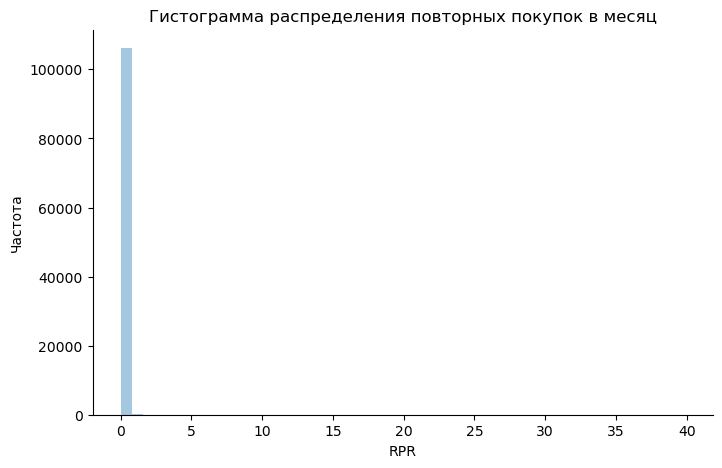

In [14]:
plt.figure(figsize=(8,5))
ax = sns.distplot(cohort_metr.RPR, kde = False)
ax.set_xlabel('RPR')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма распределения повторных покупок в месяц')
sns.despine()

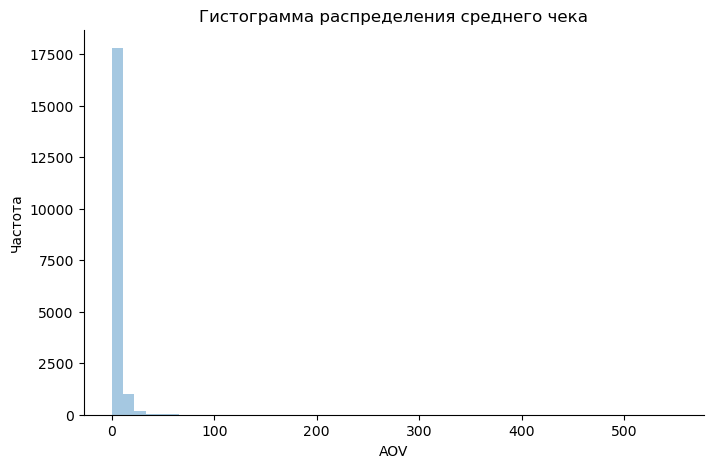

In [15]:
plt.figure(figsize=(8,5))
ax = sns.distplot(cohort_metr.AOV, kde = False)
ax.set_xlabel('AOV')
ax.set_ylabel('Частота')
ax.set_title('Гистограмма распределения среднего чека')
sns.despine()

#### Как показывают гистограммы, большинство пользователей имеют низкие показатели по повторным покупкам и среднему чеку, и очень мало пользователей имеют высокие значения этих показателей.    
#### Для дальнейшего исследования вопроса необходимо собрать данные на бОльшем промежутке времени и проанализировать показатель Retention Rate (возможно пользователи возвращаются позднее 6 месяцев).

### 3. Какая кoгорта (по месяцам первого посещения) принесла больше всего денег за полгода жизни?

In [16]:
# определим для каждого покупателя дату его первой покупки
first_visit = visits.groupby('Uid', as_index=False) \
                     .agg({'Start_Ts': 'min'}) \
                     .rename(columns={'Start_Ts':'first_visit'})
first_visit.head()

,Uid,first_visit
0,11863502262781,2018-03-01 17:27:00
1,49537067089222,2018-02-06 15:55:00
2,297729379853735,2017-06-07 18:47:00
3,313578113262317,2017-09-18 22:49:00
4,325320750514679,2017-09-30 14:29:00


In [17]:
# Объединим с таблицей заказов
cohort = first_visit.merge(orders, how='inner', on='Uid') 
cohort.head()

,Uid,first_visit,Buy_Ts,Revenue
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,0.55
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83
3,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,73.33
4,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,2.44


In [18]:
def add_month(orig_date, count_month):
    ### принимает дату образования когорты и срок ее жизни, возвращает первый день месяца, следующего за сроком жизни ###
    new_year = orig_date.year
    new_month = orig_date.month + count_month +1
    
    if new_month > 12:
        new_year += 1
        new_month -= 12
    return orig_date.replace(year=new_year, month=new_month, day=1, hour = 0, minute = 0, second = 0)

In [19]:
# Отберем записи с покупками в течении 6 месяцев жизни когорты
cohort['half_year'] = [add_month(i, 6) for i in cohort.first_visit]
cohort = cohort[cohort.Buy_Ts < cohort.half_year]
cohort['cohort_period'] = cohort['first_visit'].dt.strftime('%Y-%m')
cohort.head()

,Uid,first_visit,Buy_Ts,Revenue,half_year,cohort_period
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,0.55,2018-04-01,2017-09
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,1.22,2018-01-01,2017-06
2,1575281904278712,2017-06-03 10:13:00,2017-06-03 17:39:00,1.83,2018-01-01,2017-06
3,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,73.33,2018-05-01,2017-10
4,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,2.44,2018-08-01,2018-01


In [20]:
total_revenue = cohort.groupby('cohort_period', as_index = False) \
                      .agg({'Revenue':'sum'}) \
                      .sort_values('Revenue', ascending = False)
total_revenue

,cohort_period,Revenue
3,2017-09,32772.61
6,2017-12,31157.85
0,2017-06,27823.87
4,2017-10,27201.79
5,2017-11,24426.72
1,2017-07,15259.10
8,2018-02,15061.29
7,2018-01,14546.82
9,2018-03,13770.16
2,2017-08,11009.28


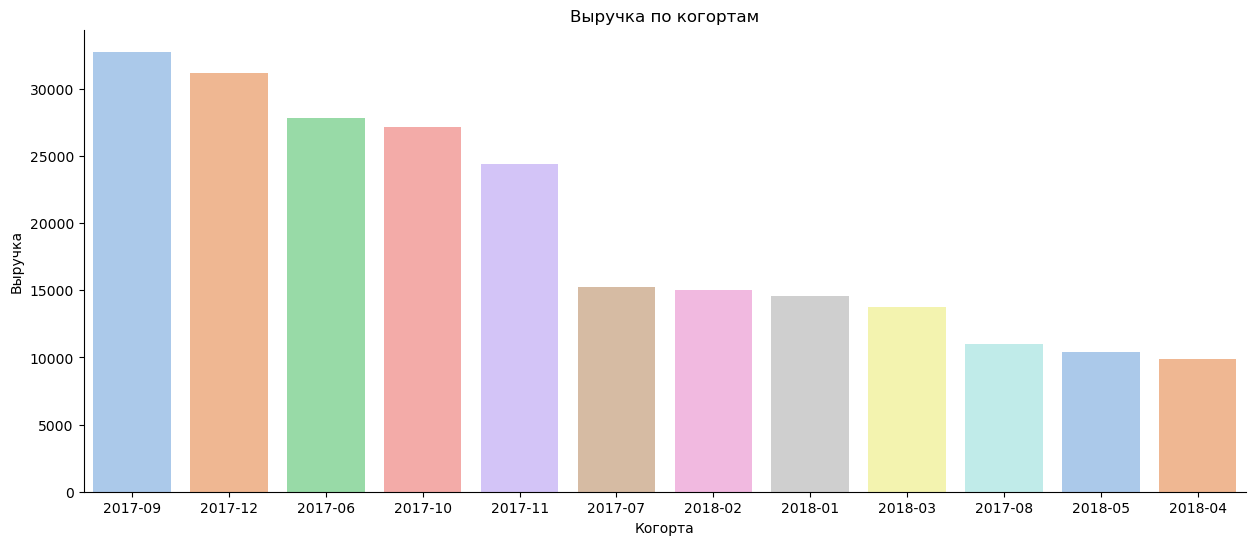

In [21]:
plt.figure(figsize=(15,6))
ax = sns.barplot(data=total_revenue, x='cohort_period', y='Revenue',  palette='pastel')
ax.set_xlabel('Когорта')
ax.set_ylabel('Выручка')
ax.set_title('Выручка по когортам')
sns.despine()

#### Когорта пользователей, пришедших в сентябре 2017 за полгода жизни принесла больше всего денег

### Спрогнозировать выручку когорт 

#### Для прогнозирования выручки возьмем за основу первую сформированню когорту и определим Revenue_Retention (как отношение Revenue к размеру когорты) по месяцам. Далее, зная размеры когорт, сможем спрогнозировать выручку

In [22]:
# определим для каждого пользователя дату его первого посещения

first_visit =visits.groupby('Uid', as_index=False) \
                                .agg({'Start_Ts': 'min'}) \
                                .rename(columns={'Start_Ts':'first_order_period'})
first_visit['first_order_period']=first_visit['first_order_period'].dt.strftime('%Y-%m')
first_visit.head()

,Uid,first_order_period
0,11863502262781,2018-03
1,49537067089222,2018-02
2,297729379853735,2017-06
3,313578113262317,2017-09
4,325320750514679,2017-09


In [23]:
# добавим колонку с датой первого посещения к таблице с заказами
df = orders.merge(first_visit, how = 'inner', on = 'Uid') 
df['order_period'] = df['Buy_Ts'].dt.strftime('%Y-%m')
df.head()

,Buy_Ts,Revenue,Uid,first_order_period,order_period
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06,2017-06
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06,2017-06
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06,2017-06
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06,2017-06
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06,2017-06


In [24]:
# определим размер когорт
size = df.groupby('first_order_period', as_index=False).agg({'Uid':'nunique'}).rename(columns={'Uid':'size_cohort'})
size

,first_order_period,size_cohort
0,2017-06,2923
1,2017-07,2458
2,2017-08,1721
3,2017-09,3058
4,2017-10,4678
5,2017-11,4262
6,2017-12,4074
7,2018-01,3119
8,2018-02,3186
9,2018-03,2838


In [25]:
# создадим датафрейм с когортами, определим Revenue_Retention
cohort = df.groupby(['first_order_period', 'order_period'], as_index=False).agg({'Revenue':'sum'})
cohort = cohort.merge(size, how = 'inner', on = 'first_order_period')
cohort['Revenue_Retention'] = round(cohort.Revenue / cohort.size_cohort, 2)
cohort.head()

,first_order_period,order_period,Revenue,size_cohort,Revenue_Retention
0,2017-06,2017-06,9557.49,2923,3.27
1,2017-06,2017-07,2664.58,2923,0.91
2,2017-06,2017-08,1464.69,2923,0.50
3,2017-06,2017-09,3882.09,2923,1.33
4,2017-06,2017-10,3940.59,2923,1.35


In [26]:
# Добавим порядковое значение периода когорты для каждой когорты

def cohort_number(date1, date2):
    period=0
    sp1=date1.split('-')
    sp2=date2.split('-')
    if date1==date2:
        period = 0
    elif sp1[0]==sp2[0]:
        period=int(sp2[1])-int(sp1[1])
    else:
        period=12-int(sp1[1])+int(sp2[1])
    return(period)

cohort['cohort_period'] = cohort.apply(lambda x: cohort_number(x['first_order_period'], x['order_period']), axis=1)
cohort.head()

,first_order_period,order_period,Revenue,size_cohort,Revenue_Retention,cohort_period
0,2017-06,2017-06,9557.49,2923,3.27,0
1,2017-06,2017-07,2664.58,2923,0.91,1
2,2017-06,2017-08,1464.69,2923,0.50,2
3,2017-06,2017-09,3882.09,2923,1.33,3
4,2017-06,2017-10,3940.59,2923,1.35,4


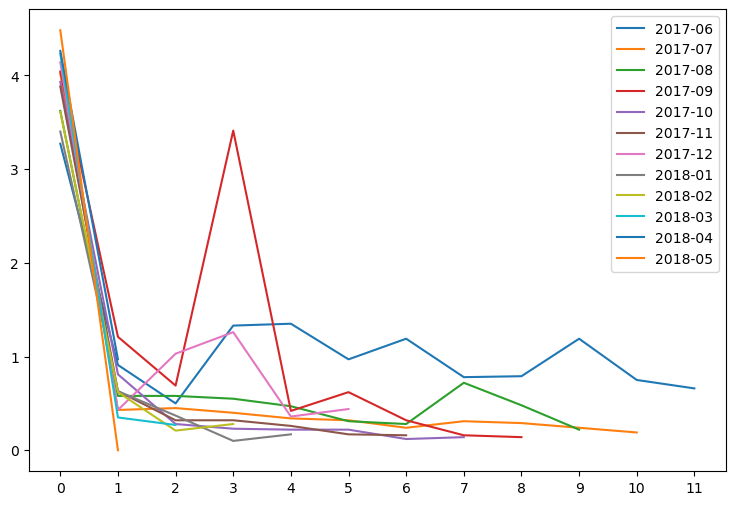

In [27]:
# Представим на графике Revenue_Retention когорт по месяцам (0- месяц формирования когорты, далее 1-ый, 2-ой и т.д. месяца)
ar_cohort = cohort.first_order_period.unique()
key=''
plt.figure(figsize=(9,6))
for i in range(len(ar_cohort)):
    key = ar_cohort[i]
    plt.plot(cohort.loc[cohort.first_order_period==key].cohort_period, cohort.loc[cohort.first_order_period==key].Revenue_Retention)
    plt.legend(ar_cohort)  
    plt.xticks(range(12))

#### Как мы видим, Revenue_Retention падает на 1-ый месяц, далее показывает небольшой всплеск на 2-3 месяцы, а затем выходит на плато.

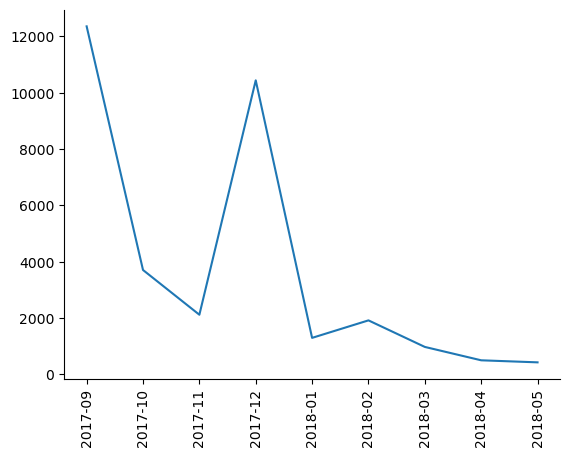

In [28]:
# Посмотрим на причину резкого скачка продаж для когорты '2017-09' в декабре 2017
plt.plot(cohort.loc[cohort.first_order_period=='2017-09'].order_period, cohort.loc[cohort.first_order_period=='2017-09'].Revenue)  
plt.xticks(rotation=90)
sns.despine()

In [29]:
# продажи когорты
df.loc[df.first_order_period=='2017-09'].sort_values('Revenue', ascending=False).head()

,Buy_Ts,Revenue,Uid,first_order_period,order_period
11732,2017-12-10 20:17:00,2633.28,5539673724080479777,2017-09,2017-12
11730,2017-12-10 13:04:00,1195.64,5539673724080479777,2017-09,2017-12
11745,2017-12-15 21:22:00,604.39,5539673724080479777,2017-09,2017-12
12643,2017-09-26 22:45:00,550.00,16152080406371512880,2017-09,2017-09
11724,2017-12-05 00:50:00,402.72,5539673724080479777,2017-09,2017-12


In [30]:
# как мы видим один пользователь из когорты совершил большие покупки в декабре 2017
a = int('5539673724080479777')
df.loc[df.Uid==a].sort_values('Revenue', ascending=False).head()

,Buy_Ts,Revenue,Uid,first_order_period,order_period
11732,2017-12-10 20:17:00,2633.28,5539673724080479777,2017-09,2017-12
11730,2017-12-10 13:04:00,1195.64,5539673724080479777,2017-09,2017-12
11745,2017-12-15 21:22:00,604.39,5539673724080479777,2017-09,2017-12
11724,2017-12-05 00:50:00,402.72,5539673724080479777,2017-09,2017-12
11728,2017-12-08 12:25:00,360.55,5539673724080479777,2017-09,2017-12


In [31]:
df.loc[df.Uid==a].order_period.unique()

array(['2017-09', '2017-11', '2017-12', '2018-01', '2018-02', '2018-03',
       '2018-04'], dtype=object)

#### В когорте 2017-09 есть пользователь, который совершил покупки на значительные суммы в декабре 2017. Также данный пользователь совершал покупки практически ежемесячно. Возможно, это оптовый покупатель.
#### Посмотрим, были ли скачки в продажах в декабре 2017 у других когорт

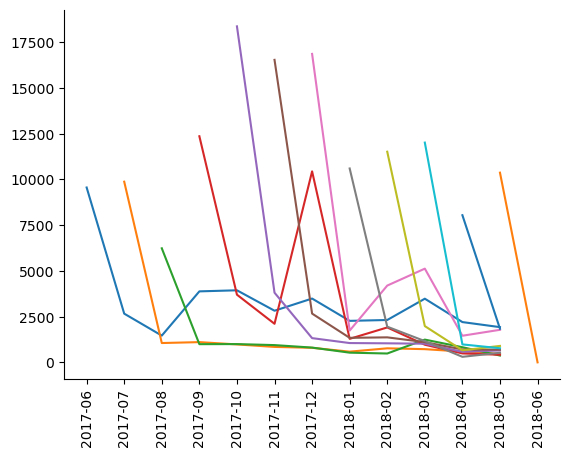

In [32]:
key=''
for i in range(len(ar_cohort)):
    key = ar_cohort[i]
    plt.plot(cohort.loc[cohort.first_order_period==key].order_period, cohort.loc[cohort.first_order_period==key].Revenue)
    plt.xticks(rotation=90)
sns.despine()

#### Скачков продаж больше не наблюдаем, поэтому считаем данного пользователя единичным случаем. Для дальнейшего прогнозирования выручки когорт будем использовать медианы, чтобы нивелировать выбросы

In [33]:
# определим медианы Revenue_Retention по месяцам
Rev_Ret = cohort.groupby('cohort_period', as_index=False).agg({'Revenue_Retention':'median'}) \
                .rename(columns={'Revenue_Retention':'Rev_Ret_med'})
Rev_Ret

,cohort_period,Rev_Ret_med
0,0,3.975
1,1,0.625
2,2,0.410
3,3,0.400
4,4,0.350
5,5,0.320
6,6,0.260
7,7,0.310
8,8,0.385
9,9,0.240


In [34]:
# таблица выручки когорт по месяцам
table = cohort.set_index(['first_order_period', 'cohort_period'])['Revenue'].unstack(1)
table

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_order_period,,,,,,,,,,,,
2017-06,9557.49,2664.58,1464.69,3882.09,3940.59,2824.48,3489.95,2270.81,2317.91,3481.64,2204.01,1927.81
2017-07,9874.89,1059.28,1108.90,982.96,846.99,798.08,588.00,770.30,724.52,591.03,467.16,NaN
2017-08,6234.81,997.32,1001.35,946.21,810.04,532.90,486.65,1246.23,830.64,375.72,NaN,NaN
2017-09,12357.20,3700.48,2110.63,10438.93,1288.48,1910.05,966.84,491.38,418.57,NaN,NaN,NaN
2017-10,18362.32,3809.83,1327.02,1058.05,1043.47,1022.19,578.91,655.90,NaN,NaN,NaN,NaN
2017-11,16531.79,2667.58,1342.85,1369.53,1108.74,707.63,698.60,NaN,NaN,NaN,NaN,NaN
2017-12,16857.00,1739.03,4198.30,5123.82,1457.57,1782.13,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,10597.01,1951.70,1164.76,305.88,527.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,11512.63,1984.46,663.19,901.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### У когорты 2018-05 данные по выручке за 1-ый месяц не полные

In [35]:
df.loc[df.first_order_period=='2018-05'].groupby('order_period', as_index=False).agg({'Revenue':'sum'})

,order_period,Revenue
0,2018-05,10368.11
1,2018-06,3.42


In [36]:
df.groupby('first_order_period', as_index=False).agg({'Buy_Ts':'max'})

,first_order_period,Buy_Ts
0,2017-06,2018-05-31 21:57:00
1,2017-07,2018-05-31 22:11:00
2,2017-08,2018-05-31 20:07:00
3,2017-09,2018-05-31 22:19:00
4,2017-10,2018-05-31 23:56:00
5,2017-11,2018-05-31 22:31:00
6,2017-12,2018-05-31 23:43:00
7,2018-01,2018-05-31 19:08:00
8,2018-02,2018-05-31 20:10:00
9,2018-03,2018-05-31 23:40:00


#### По всем когортм даты последних платежей приходятся на 2018-05-31. Удалим неполные данные за 2018-06 (далее спрогнозируем их)

In [37]:
cohort = cohort.loc[cohort.order_period != '2018-06']
cohort.head()

,first_order_period,order_period,Revenue,size_cohort,Revenue_Retention,cohort_period
0,2017-06,2017-06,9557.49,2923,3.27,0
1,2017-06,2017-07,2664.58,2923,0.91,1
2,2017-06,2017-08,1464.69,2923,0.50,2
3,2017-06,2017-09,3882.09,2923,1.33,3
4,2017-06,2017-10,3940.59,2923,1.35,4


In [38]:
# таблица выручки когорт по месяцам
table = cohort.set_index(['first_order_period', 'cohort_period'])['Revenue'].unstack(1)
table

cohort_period,0,1,2,3,4,5,6,7,8,9,10,11
first_order_period,,,,,,,,,,,,
2017-06,9557.49,2664.58,1464.69,3882.09,3940.59,2824.48,3489.95,2270.81,2317.91,3481.64,2204.01,1927.81
2017-07,9874.89,1059.28,1108.90,982.96,846.99,798.08,588.00,770.30,724.52,591.03,467.16,NaN
2017-08,6234.81,997.32,1001.35,946.21,810.04,532.90,486.65,1246.23,830.64,375.72,NaN,NaN
2017-09,12357.20,3700.48,2110.63,10438.93,1288.48,1910.05,966.84,491.38,418.57,NaN,NaN,NaN
2017-10,18362.32,3809.83,1327.02,1058.05,1043.47,1022.19,578.91,655.90,NaN,NaN,NaN,NaN
2017-11,16531.79,2667.58,1342.85,1369.53,1108.74,707.63,698.60,NaN,NaN,NaN,NaN,NaN
2017-12,16857.00,1739.03,4198.30,5123.82,1457.57,1782.13,NaN,NaN,NaN,NaN,NaN,NaN
2018-01,10597.01,1951.70,1164.76,305.88,527.47,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02,11512.63,1984.46,663.19,901.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Спрогнозируем данные по Revenue для всех когорт до 11-го месяца (пустые значения в таблице): умножим рзмер когорты на медиану Revenue_Retention (на соответствующий месяц.)

In [39]:
for i, row in table.iterrows():
    for j in range(12):
        if np.isnan(row[j]):            
            row[j] = size.loc[size.first_order_period==i].size_cohort.values * Rev_Ret.loc[Rev_Ret.cohort_period==j].Rev_Ret_med.values         

In [40]:
# таблица с прогнозами
table.reset_index(inplace=True)
table

cohort_period,first_order_period,0,1,2,3,4,5,6,7,8,9,10,11
0,2017-06,9557.49,2664.58,1464.69,3882.09,3940.59,2824.48,3489.95,2270.81,2317.910,3481.64,2204.01,1927.81
1,2017-07,9874.89,1059.28,1108.90,982.96,846.99,798.08,588.00,770.30,724.520,591.03,467.16,1622.28
2,2017-08,6234.81,997.32,1001.35,946.21,810.04,532.90,486.65,1246.23,830.640,375.72,808.87,1135.86
3,2017-09,12357.20,3700.48,2110.63,10438.93,1288.48,1910.05,966.84,491.38,418.570,733.92,1437.26,2018.28
4,2017-10,18362.32,3809.83,1327.02,1058.05,1043.47,1022.19,578.91,655.90,1801.030,1122.72,2198.66,3087.48
5,2017-11,16531.79,2667.58,1342.85,1369.53,1108.74,707.63,698.60,1321.22,1640.870,1022.88,2003.14,2812.92
6,2017-12,16857.00,1739.03,4198.30,5123.82,1457.57,1782.13,1059.24,1262.94,1568.490,977.76,1914.78,2688.84
7,2018-01,10597.01,1951.70,1164.76,305.88,527.47,998.08,810.94,966.89,1200.815,748.56,1465.93,2058.54
8,2018-02,11512.63,1984.46,663.19,901.01,1115.10,1019.52,828.36,987.66,1226.610,764.64,1497.42,2102.76
9,2018-03,12011.39,984.00,774.77,1135.20,993.30,908.16,737.88,879.78,1092.630,681.12,1333.86,1873.08


In [41]:
# рассчитаем средний LTV когорт
table['LTV'] = table[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]].sum(axis=1).round(2)
table

cohort_period,first_order_period,0,1,2,3,4,5,6,7,8,9,10,11,LTV
0,2017-06,9557.49,2664.58,1464.69,3882.09,3940.59,2824.48,3489.95,2270.81,2317.910,3481.64,2204.01,1927.81,40026.05
1,2017-07,9874.89,1059.28,1108.90,982.96,846.99,798.08,588.00,770.30,724.520,591.03,467.16,1622.28,19434.39
2,2017-08,6234.81,997.32,1001.35,946.21,810.04,532.90,486.65,1246.23,830.640,375.72,808.87,1135.86,15406.60
3,2017-09,12357.20,3700.48,2110.63,10438.93,1288.48,1910.05,966.84,491.38,418.570,733.92,1437.26,2018.28,37872.02
4,2017-10,18362.32,3809.83,1327.02,1058.05,1043.47,1022.19,578.91,655.90,1801.030,1122.72,2198.66,3087.48,36067.58
5,2017-11,16531.79,2667.58,1342.85,1369.53,1108.74,707.63,698.60,1321.22,1640.870,1022.88,2003.14,2812.92,33227.75
6,2017-12,16857.00,1739.03,4198.30,5123.82,1457.57,1782.13,1059.24,1262.94,1568.490,977.76,1914.78,2688.84,40629.90
7,2018-01,10597.01,1951.70,1164.76,305.88,527.47,998.08,810.94,966.89,1200.815,748.56,1465.93,2058.54,22796.58
8,2018-02,11512.63,1984.46,663.19,901.01,1115.10,1019.52,828.36,987.66,1226.610,764.64,1497.42,2102.76,24603.36
9,2018-03,12011.39,984.00,774.77,1135.20,993.30,908.16,737.88,879.78,1092.630,681.12,1333.86,1873.08,23405.17


In [42]:
print('Средний LTV пользователей за год составил:', round(table.LTV.mean()))

Средний LTV пользователей за год составил: 27598


In [43]:
# преобразуем сводную таблицу  вплоскую для построения графика
pr = table[['first_order_period', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]]
per_melt = pd.melt(pr, id_vars=['first_order_period'], value_vars=[0,1,2,3,4,5,6,7,8,9,10,11])
per_melt

,first_order_period,cohort_period,value
0,2017-06,0,9557.49
1,2017-07,0,9874.89
2,2017-08,0,6234.81
3,2017-09,0,12357.20
4,2017-10,0,18362.32
...,...,...,...
139,2018-01,11,2058.54
140,2018-02,11,2102.76
141,2018-03,11,1873.08
142,2018-04,11,1247.40


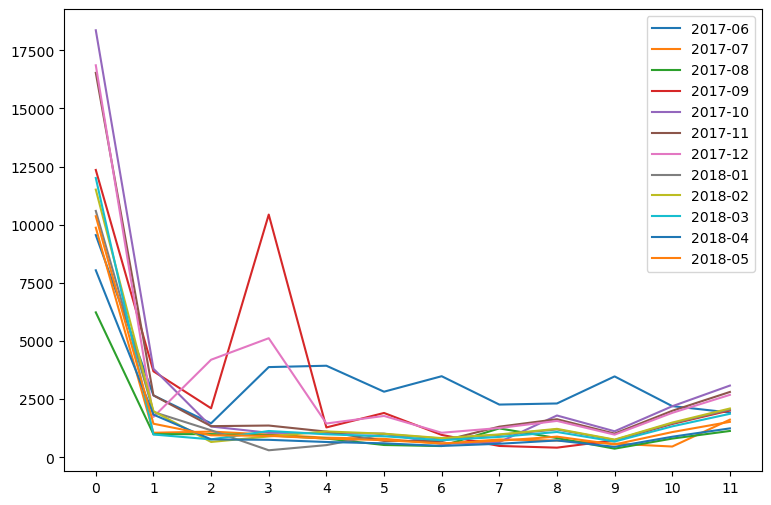

In [44]:
# Представим на графике Revenue когорт по месяцам (0- месяц формирования когорты, далее 1-ый, 2-ой и т.д. месяца)
ar_cohort = per_melt.first_order_period.unique()
key=''
plt.figure(figsize=(9,6))
for i in range(len(ar_cohort)):
    key = ar_cohort[i]
    plt.plot(per_melt.loc[per_melt.first_order_period==key].cohort_period, per_melt.loc[per_melt.first_order_period==key].value)
    plt.legend(ar_cohort)  
    plt.xticks(range(12))

In [46]:
# сохраним исходные данные в файл для построения дашборда
first_visit =visits.groupby('Uid', as_index=False) \
                                .agg({'Start_Ts': 'min'}) \
                                .rename(columns={'Start_Ts':'first_order_period'})
df_new = orders.merge(first_visit, how = 'left', on = 'Uid') 
df_new.to_csv('data_for_tableau.csv', index=False)